In [1]:
from dist_tools import *

%matplotlib inline

seats, fips, epsg = 13, 12, 3513
years = [2008]
cols = ["D08", "R08"]

In [2]:
! ls /media/jsaxon/brobdingnag/data/el_dv/fl/

fl_final.dbf  fl_final.sbx  fl_final.tab       FL_Shapefile.zip
fl_final.prj  fl_final.shp  FL_notes_0927.rtf  MANIFEST.TXT
fl_final.sbn  fl_final.shx  fl_proj.qqs.qgs


In [3]:
votes = gpd.read_file("/media/jsaxon/brobdingnag/data/el_dv/fl/fl_final.shp").to_crs(epsg = epsg)
votes.rename(columns = {"PRES_DEM_0" : "D08", "PRES_REP_0" : "R08"}, inplace = True)
votes = votes[["D08", "R08", "geometry"]]

print(list(votes.columns))

['D08', 'R08', 'geometry']


In [4]:
query = """SELECT 
              rn, ST_Centroid(ST_Transform(tr.geom, epsg)) geometry
           FROM census_tracts_2015 AS tr
           JOIN (SELECT state, county, tract,
                        row_number() over 
                          (PARTITION BY state ORDER BY county, tract NULLS LAST) - 1 as rn
                 FROM census_tracts_2015) rn ON
                   tr.state  = rn.state  AND
                   tr.county = rn.county AND
                   tr.tract  = rn.tract
           JOIN states AS st ON st.fips = tr.state
           WHERE tr.state = {} ORDER BY rn;
           """

con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)

tr_rn = gpd.GeoDataFrame.from_postgis(query.format(fips), con, index_col = "rn",
                                      geom_col = "geometry", crs = from_epsg(epsg))

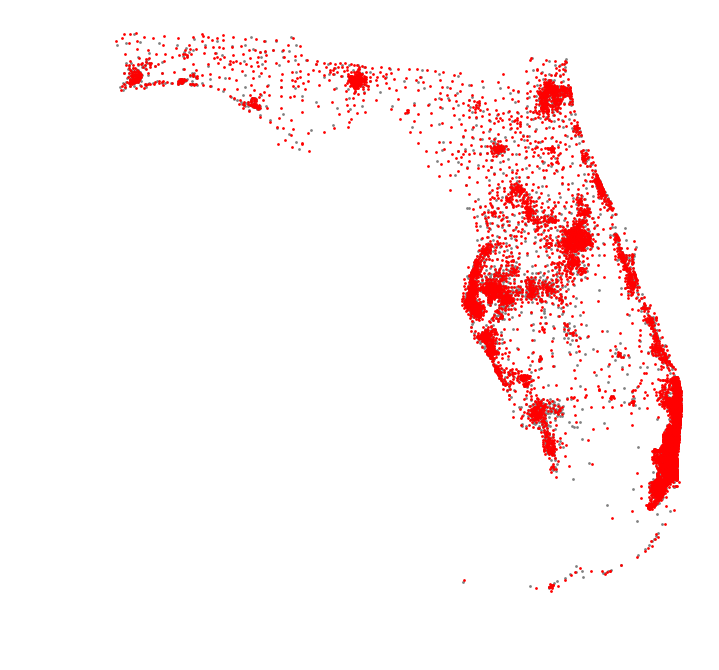

In [5]:
ax = tr_rn.plot(color = "grey", figsize = (8, 8))
votes.centroid.plot(color = "red", ax = ax)
ax.set_axis_off()

In [6]:
votes["rn"] = float('nan')
for pri, row in votes.iterrows():
    ctr = row.geometry.centroid
    distances = [(xi, pt.distance(ctr)) for xi, pt in enumerate(tr_rn.centroid)]
    match = min(distances, key=lambda item:item[1])
    votes.loc[pri, "rn"] = match[0]
    if (pri % 100) == 0: print(pri, end = " ")
print()

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 


In [11]:
votes = votes.groupby("rn").sum()[["D08", "R08"]]
votes.to_csv("fl_votes.csv")
votes.head(10)

,D08,R08
rn,,
0.0,1950.0,357.0
1.0,1218.0,325.0
2.0,1213.0,609.0
3.0,1036.0,220.0
4.0,1881.0,340.0
5.0,1693.0,55.0
6.0,1767.0,101.0
7.0,1299.0,311.0
8.0,1526.0,549.0
